# Histopathologic Cancer Detection using CNNs

**Objective:** Create a Convolutional Neural Network (CNN) model capable of identifying metastatic cancer in small images taken from larger digital pathology scans of lymph node sections. This binary classification task uses data obtained from the Kaggle Histopathologic Cancer Detection dataset.

**Dataset:** The dataset consists of thousands of 96x96 pixel RGB image patches. A positive label (1) indicates that the central 32x32 pixel region of the patch contains at least one pixel of tumor tissue. A negative label (0) indicates no tumor tissue in the central region.

## 1. Setup and Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Data Loading and Exploration

In [2]:
BASE_PATH = "~/histopathologic-cancer-detection/"

TRAIN_DIR = os.path.join(BASE_PATH, 'train/')
TEST_DIR = os.path.join(BASE_PATH, 'test/')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'train_labels.csv')

In [3]:
df_labels = pd.read_csv(TRAIN_LABELS_PATH)
df_labels['id'] = df_labels['id'].apply(lambda x: f"{x}.tif")

print("\nFirst 5 rows of labels:")
print(df_labels.head())


First 5 rows of labels:
                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0


label
0    59.496875
1    40.503125
Name: proportion, dtype: float64


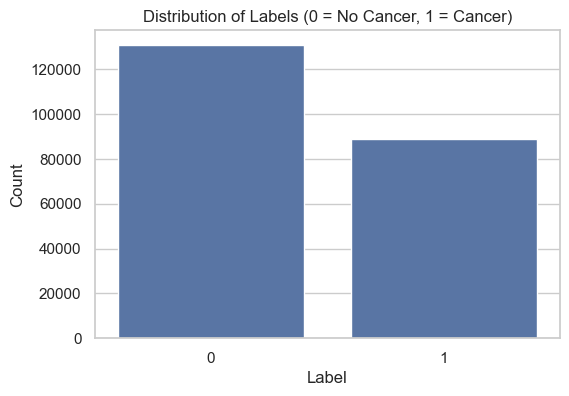

In [4]:
label_counts = df_labels['label'].value_counts(normalize=True) * 100
print(label_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_labels)
plt.title('Distribution of Labels (0 = No Cancer, 1 = Cancer)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

#### The dataset is somewhat imbalanced (~60% negative, ~40% positive). This isn't extreme imbalance, but we should keep it in mind for evaluation.


In [5]:
def display_samples(df, n_samples=5):
    """Displays random samples from the dataframe."""
    samples = df.sample(n_samples)
    plt.figure(figsize=(15, n_samples * 1.5)) # Adjust figure size
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(TRAIN_DIR, row['id'])
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not load image {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV loads as BGR

            plt.subplot(n_samples // 5 + 1, 5, i + 1)
            plt.imshow(img)
            plt.title(f"ID: ...{row['id'][-10:]}\nLabel: {row['label']}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading/plotting image {img_path}: {e}")

    plt.tight_layout()
    plt.show()
    return


Displaying random samples (Label 0 - No Cancer):


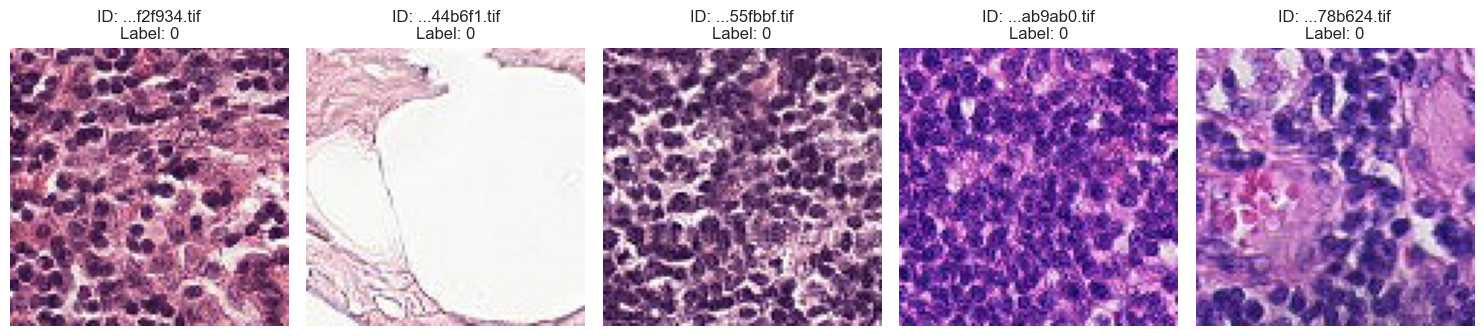

In [6]:
print("\nDisplaying random samples (Label 0 - No Cancer):")
display_samples(df_labels[df_labels['label'] == 0])


Displaying random samples (Label 1 - Cancer):


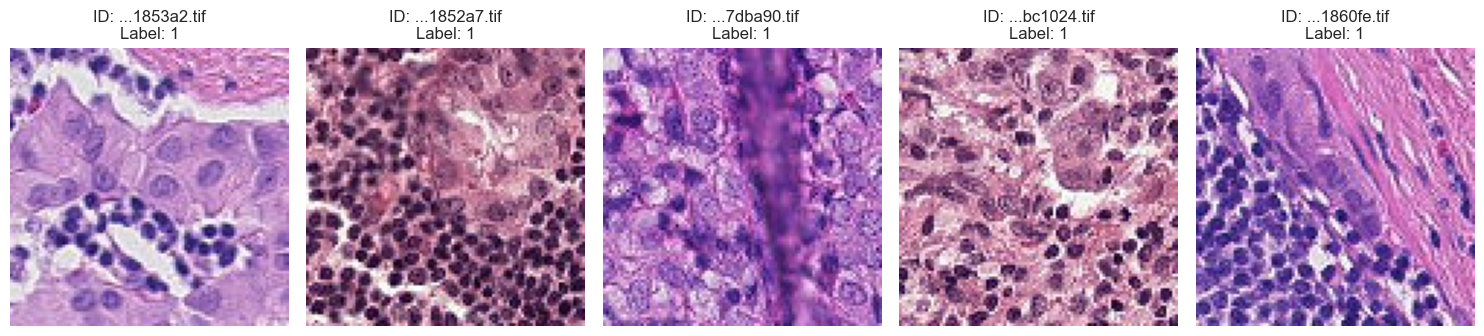

In [7]:
print("\nDisplaying random samples (Label 1 - Cancer):")
display_samples(df_labels[df_labels['label'] == 1])

## 3. Data Preprocessing and Pipeline

In [8]:
IMG_WIDTH, IMG_HEIGHT = 96, 96
BATCH_SIZE = 64
SEED = 42

df_labels['label'] = df_labels['label'].astype(str)

train_df, val_df = train_test_split(
    df_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=df_labels['label']
)

print(f"\nTraining set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")


Training set size: 176020
Validation set size: 44005


In [9]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,  
    rotation_range=20,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.1,        
    zoom_range=0.1,          
    horizontal_flip=True,    
    vertical_flip=True,      
    fill_mode='nearest'     
)

# Create generators from dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

val_datagen = ImageDataGenerator(rescale=1./255.)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [10]:
# Verify generator output shapes
x_batch, y_batch = next(train_generator)
print(f"\nSample batch shape (images): {x_batch.shape}")
print(f"Sample batch shape (labels): {y_batch.shape}")


Sample batch shape (images): (64, 96, 96, 3)
Sample batch shape (labels): (64,)


## 4. CNN Model Building

In [11]:
def build_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    model = Sequential(name="Histopathologic_CNN")

    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',      
        metrics=[
            'accuracy',                   
            tf.keras.metrics.AUC(name='auc') 
        ]
    )
    return model

In [12]:
model = build_cnn_model()
model.summary()

2025-04-26 18:41:16.120443: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 18:41:16.120564: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-26 18:41:16.120571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-26 18:41:16.120654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 18:41:16.120674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Histopathologic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                               

## 5. Model Training

In [13]:
MODEL_CHECKPOINT_PATH = 'best_cancer_cnn_model.keras'

steps_per_epoch = np.ceil(train_generator.samples / BATCH_SIZE).astype(int)
validation_steps = np.ceil(validation_generator.samples / BATCH_SIZE).astype(int)

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 2751
Validation steps: 688


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/25


2025-04-26 18:41:16.926448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2751/2751 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8209 - auc: 0.8901

2025-04-26 18:46:53.307065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2751/2751 [==============================] - 360s 131ms/step - loss: 0.4110 - accuracy: 0.8209 - auc: 0.8901 - val_loss: 0.5383 - val_accuracy: 0.7527 - val_auc: 0.9247
Epoch 2/25
2751/2751 [==============================] - 353s 128ms/step - loss: 0.3333 - accuracy: 0.8575 - auc: 0.9284 - val_loss: 0.5576 - val_accuracy: 0.7734 - val_auc: 0.8528
Epoch 3/25
2751/2751 [==============================] - 357s 130ms/step - loss: 0.2987 - accuracy: 0.8755 - auc: 0.9426 - val_loss: 1.2485 - val_accuracy: 0.5859 - val_auc: 0.6208
Epoch 4/25
2751/2751 [==============================] - 364s 132ms/step - loss: 0.2786 - accuracy: 0.8852 - auc: 0.9499 - val_loss: 0.9418 - val_accuracy: 0.6502 - val_auc: 0.9013
Epoch 5/25
2751/2751 [==============================] - 365s 133ms/step - loss: 0.2668 - accuracy: 0.8915 - auc: 0.9541 - val_loss: 1.2594 - val_accuracy: 0.6465 - val_auc: 0.8162
Epoch 6/25
2751/2751 [==============================] - 377s 137ms/step - loss: 0.2561 - accuracy: 0.8962 - auc

## 6. Model Evaluation

In [17]:
# model.load_weights(MODEL_CHECKPOINT_PATH)

validation_generator.reset()
loss, accuracy, auc_score = model.evaluate(validation_generator, steps=validation_steps, verbose=1)

print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation AUC: {auc_score:.4f}")

688/688 [==============================] - 22s 32ms/step - loss: 0.3407 - accuracy: 0.8589 - auc: 0.9618

Validation Loss: 0.3407
Validation Accuracy: 0.8589
Validation AUC: 0.9618


In [23]:
validation_generator.reset()
y_pred_proba = model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

y_true = validation_generator.classes

if len(y_pred) != len(y_true):
    y_pred = y_pred[:len(y_true)]
    y_pred_proba = y_pred_proba[:len(y_true)]

  2/688 [..............................] - ETA: 44s 

2025-04-26 21:25:38.617134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


688/688 [==============================] - 22s 32ms/step


In [24]:
print("\nClassification Report:")
target_names = ['Class 0 (No Cancer)', 'Class 1 (Cancer)']
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
                     precision    recall  f1-score   support

Class 0 (No Cancer)       0.82      0.99      0.89     26182
   Class 1 (Cancer)       0.97      0.67      0.79     17823

           accuracy                           0.86     44005
          macro avg       0.89      0.83      0.84     44005
       weighted avg       0.88      0.86      0.85     44005




Confusion Matrix:


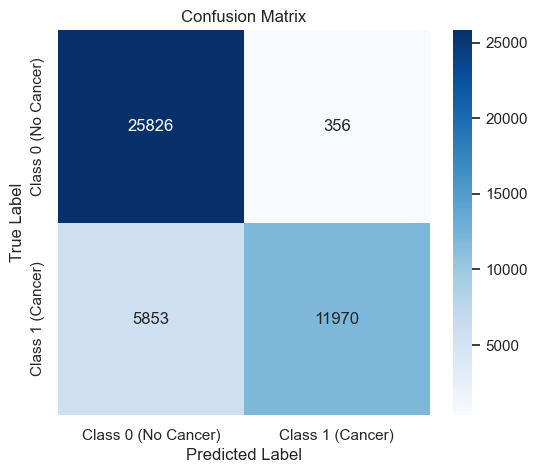

In [25]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ROC Curve:


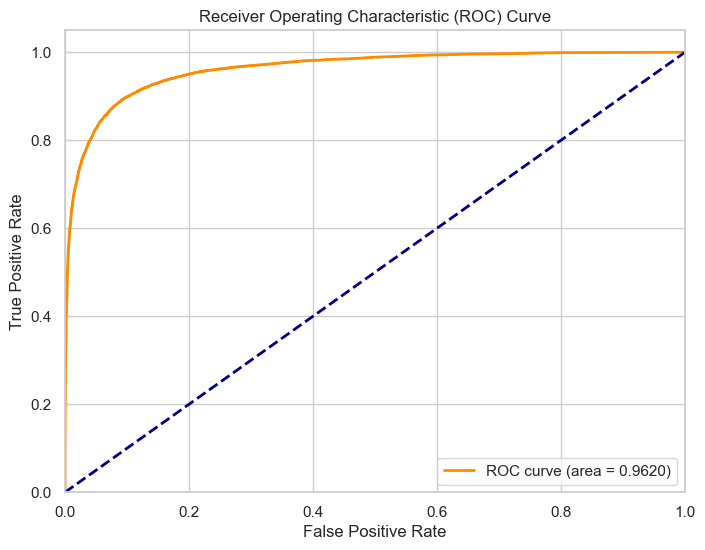

In [26]:
print("\nROC Curve:")
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
def plot_history(history):
    """Plots training & validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return

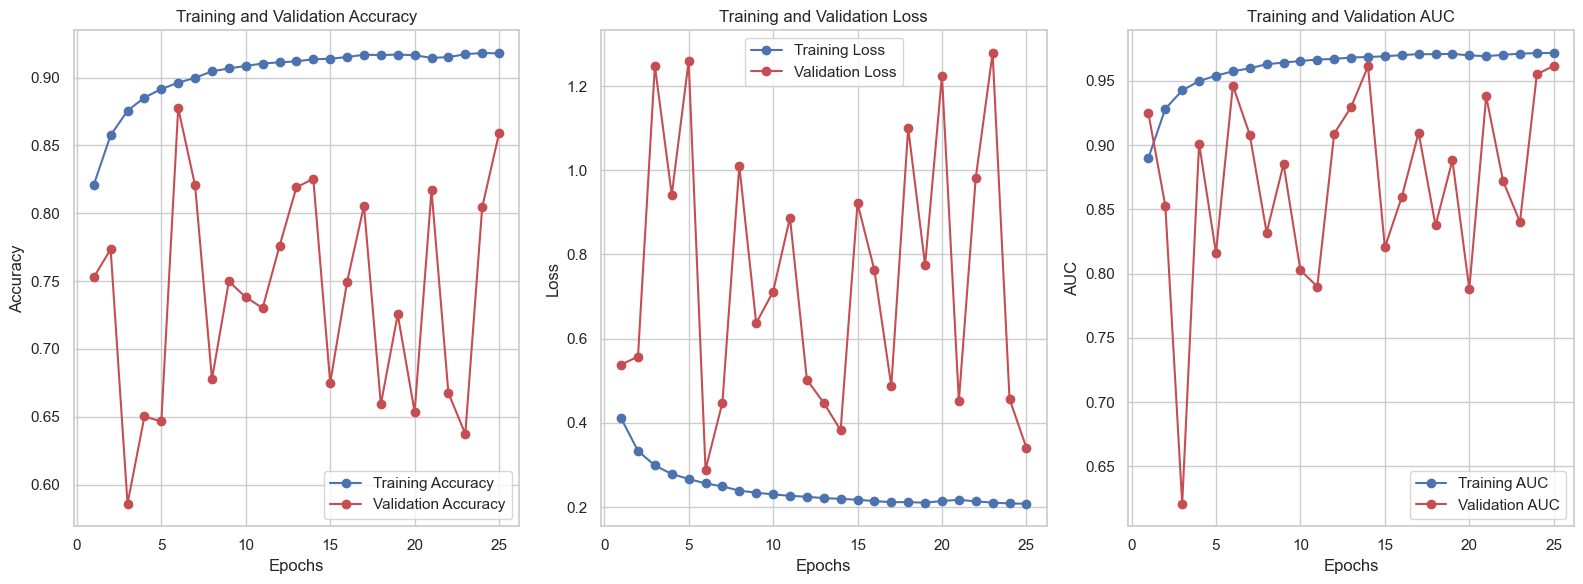

In [28]:
plot_history(history)

## 7. Prediction on Test Set

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_files = os.listdir(TEST_DIR)
test_df = pd.DataFrame({'id': test_files})

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col='id',
    y_col=None, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, 
    class_mode=None, 
    shuffle=False
)

Found 57458 validated image filenames.


In [30]:
test_steps = np.ceil(test_generator.samples / BATCH_SIZE).astype(int)
test_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

  5/898 [..............................] - ETA: 14s 

2025-04-26 21:26:02.991030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


898/898 [==============================] - 20s 22ms/step


In [39]:
submission_df = pd.DataFrame({
    'id': [os.path.splitext(f)[0] for f in test_generator.filenames], 
    'label': test_pred_proba.flatten().round()
})

if len(submission_df) != len(test_df):
    print(f"Warning: Submission length ({len(submission_df)}) doesn't match test set length ({len(test_df)}).")
else:
    SUBMISSION_PATH = "~/histopathologic-cancer-detection/submission.csv"
    submission_df.to_csv(SUBMISSION_PATH, index=False)